In [1]:
# If using Google Drive for storing models and loading data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip -q install transformers[torch] datasets evaluate wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.7/251.7 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.9 MB/s eta 0:00:00


See the image classification [task page](https://huggingface.co/tasks/image-classification) for more information about its associated models, datasets, and metrics.

https://wandb.ai/ is used for logging results. Comment out if you are not interested in using it.

In [3]:
from datasets import load_dataset, Image, Dataset, DatasetDict
from transformers import DefaultDataCollator, AutoImageProcessor
from pathlib import Path

import torch.nn.functional as f
import torch
import os

from PIL import Image as PILImage
import wandb
import pandas as pd
import numpy as np
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Prep Dataset

In [4]:
working_directory = Path('/content/drive/MyDrive/Projects/motes-figural') #@param {type:"raw"}
project_data_dir = working_directory / 'data' #@param {type:"raw"}
img_dir = project_data_dir / 'outputs' #@param {type:"raw"}
gt_dir = project_data_dir / 'truth' #@param {type:"raw"}

seed = 1234 #@param {type:"integer"}
##booklet = 'b' #@param ["a", "b"] # using BOTH booklets together
##name = f"motes_figural_booklet{booklet}" #@param {type:"string"}
name = "motes_figural_both" #@param {type:"string"}

classification_model = "microsoft/beit-large-patch16-224-pt22k-ft22k" #@param ["google/vit-large-patch16-224", "microsoft/beit-large-patch16-224-pt22k-ft22k", "facebook/convnext-base-224", "microsoft/resnet-50", "google/vit-base-patch16-384", "microsoft/beit-base-patch16-224-pt22k-ft22k", "google/vit-base-patch16-224"]
%env WANDB_PROJECT=$name

modeldir = project_data_dir / 'models' / (name+'_'+classification_model.replace('/','-'))
modeldir.mkdir(exist_ok=True)


env: WANDB_PROJECT=motes_figural_both


### General Prep

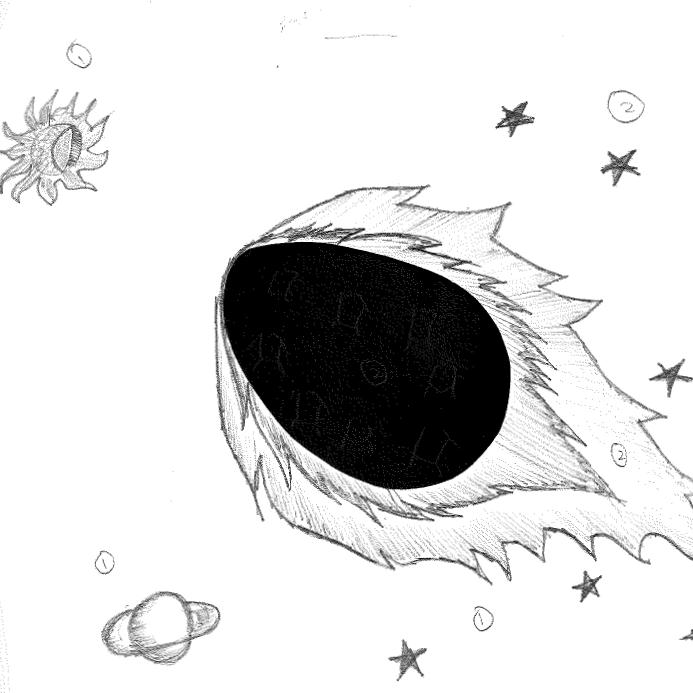

Dropping 26 rows without a id value
Dropping 5 rows without a activity value


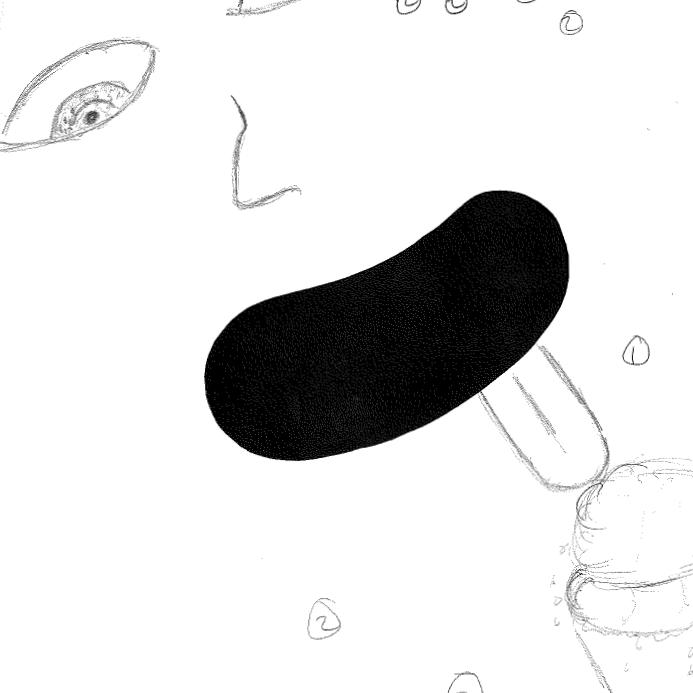

Data split sizes


train    0.86
test     0.10
val      0.04
Name: split, dtype: float64

train    8229
test      947
val       387
Name: split, dtype: int64

9563


In [5]:
rng = np.random.default_rng(seed=seed)

booklets = []

for booklet in ['a', 'b']:
    bookletdata = pd.read_csv(gt_dir / f'ttct_booklet{booklet}_ground_truth.csv')
    bookletdata.task = bookletdata.task.str.strip()
    bookletdata.activity = bookletdata.activity.str.strip()

    # remove rows with missing data
    for col in ['id', 'activity', 'task']:
        missing = bookletdata[col].isna()
        if missing.sum():
            print(f"Dropping {missing.sum()} rows without a {col} value")
            bookletdata = bookletdata[~missing]

    # add img paths if they don't already exist
    #if 'img_path' not in bookletdata:
    bookletdata['img_path'] = bookletdata.apply(lambda x: img_dir / x.task / x.activity / f"{x['id']}.jpg", axis=1)
    display(PILImage.open(bookletdata['img_path'].iloc[0]))
    booklets.append(bookletdata)

data = pd.concat(booklets)


#data = data[['img_path', 'booklet', 'id', 'pdf_path', 'titlepage', 'F', 'O', 'T', 'E', 'R', 'C', 'ame']]
# 10% for test set
test_prop = 0.1
val_prop = 0.04

data['split'] = 'train'
randv = rng.random(size=len(data))
data.loc[(randv < test_prop+val_prop), 'split'] = 'val'
data.loc[(randv < test_prop), 'split'] = 'test'
print("Data split sizes")
display((data.split.value_counts() / len(data)).round(2))
display(data.split.value_counts())

# remove missing or improper data
#data = data[~data.img_path.isna()]

data['img_path'] = data.img_path.apply(lambda x: Path(x))
data['testset'] = (rng.random(size=len(data)) < test_prop)
data['activity'] = data.img_path.apply(lambda x: x.parent.stem)
# id-encode activity
activities = data['activity'].unique().tolist()
id2activity = {i:x for i, x in enumerate(activities)}
activity2id = {x:i for i, x in enumerate(activities)}
data['activity_id'] = data.activity.replace(activity2id)

print(len(data))

In [7]:
for measure_data in ['blank_sim.csv', 'avg_sim.csv', 'elaboration.csv', 'zero_sim.csv']:
    x = pd.read_csv(project_data_dir / 'metrics'/measure_data)
    x = x[(x.test == 'ttct') & (x.task == f'booklet{booklet}')]
    x = x.drop(columns=[y for y in ['path', 'cropped', 'contrast'] if y in x.columns])
    data = data.merge(x)
# remove some data errors
data.loc[data['F'] > 1, 'F'] = np.NaN
data.loc[data['T'] > 3, 'T'] = np.NaN
data.loc[data['R'] > 2, 'R'] = np.NaN

def fix_path(x):
    y= (project_data_dir / 'outputs' / x.task.lower() / x.img_path.parent.name / x.img_path.name)
    return y
data.img_path = data.apply(fix_path, axis=1)

# ignore missing/corrupted images
data['img_exists'] = data.img_path.apply(lambda x: os.path.exists(x) and (os.stat(x).st_size != 0))
data = data[data.img_exists]

# ignore missing data
data = data[~data.O.isna()]
data = data[data.O.isin([0,1])]
data.O = data.O.astype(int)

print(len(data))
data.sample(1)

6096


,img_path,task,activity,id,F,O,T,E,R,C,...,contrast_factor,crop_bottom,test,avg_dist,elaboration_raw,zlist_least_dist,zlist_most_dist,zlist_mean_dist,zlist_3least_dist,img_exists
3274,/content/drive/MyDrive/Projects/motes-figural/...,bookletb,activity2c,f520c-78234,1.0,1,2.0,1,1.0,1,...,4,False,ttct,0.236456,0.063235,0.716329,0.771228,0.741498,0.722329,True


In [8]:
# Create dataset
labels = ["Not Original", "Original"]
id2label = {str(i):x for i, x in enumerate(labels)}
label2id = {v:k for k,v in id2label.items()}

# Create dataset
datasets = {}
for split in ['test', 'train', 'val']:
    subset = data[(data.split == split)]
    datasets[split] = Dataset.from_dict({'image': subset.img_path.astype(str),
                                         'activity': subset.activity_id.astype(int),
                                         'label': subset.O}).cast_column("image", Image()).shuffle(seed=seed)

rawdataset = DatasetDict(datasets)
rawdataset

DatasetDict({
    test: Dataset({
        features: ['image', 'activity', 'label'],
        num_rows: 646
    })
    train: Dataset({
        features: ['image', 'activity', 'label'],
        num_rows: 5214
    })
    val: Dataset({
        features: ['image', 'activity', 'label'],
        num_rows: 236
    })
})

### Model-Specific Prep

Transformations and normalization. Final reported models do not apply any.

In [9]:
from torchvision.transforms import RandomResizedCrop, RandomHorizontalFlip, Resize, Compose, Normalize, ToTensor, RandomInvert
import warnings

one_hot = False #@param {type:"boolean"}
if one_hot:
    warnings.warn("The current one-hot strategy likely won't make a difference because of the patches in VITs. A better strategy would be to change the token in the feature extraction")
invert_prob = 0 #@param {type:"slider", min:0, max:1, step:0.5}
random_crop = False #@param {type:"boolean"}
random_hflip = False #@param {type:'boolean'}

image_processor = AutoImageProcessor.from_pretrained(classification_model)
if "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
else:
    size = (image_processor.size["height"], image_processor.size["width"])
print("image size:", size)

pipeline = []
normalize = Normalize(mean=image_processor.image_mean,
                      std=image_processor.image_std)

if random_crop:
    pipeline.append(RandomResizedCrop(size))
else:
    pipeline.append(Resize(size))

if random_hflip:
    pipeline.append(RandomHorizontalFlip(p=0.5))

if invert_prob > 0:
    pipeline.append(RandomInvert(p=invert_prob)) # possibly force it to look for signal beyond ink

pipeline += [ToTensor(), normalize]
_transforms = Compose(pipeline)

def one_hot_pad(input):
    pixel_values, activity = input
    pixel_values[:, :len(activities), 0] = f.one_hot(torch.tensor(activity), num_classes=len(activities))
    return pixel_values

one_hot_transform = Compose([one_hot_pad])

def transforms(examples, one_hot=False):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    if one_hot:
        examples["pixel_values"] = [one_hot_transform((px, act)) for px, act in zip(examples['pixel_values'], examples['activity'])]
    del examples["image"]
    del examples['activity']
    return examples

dataset = rawdataset.with_transform(lambda x: transforms(x, one_hot))

preprocessor_config.json:   0%|          | 0.00/276 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


image size: (224, 224)


## Train

In [10]:
import numpy as np
import evaluate
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer, EarlyStoppingCallback

accuracy = evaluate.load("accuracy")
f1 = evaluate.load('f1')
pearson = evaluate.load("pearsonr")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
roc_auc = evaluate.load("roc_auc")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # this is a classification problem, so use predictions rather than logits
    predictions = np.argmax(eval_pred.predictions, axis=1)
    metrics = {}
    for metric in [accuracy, f1, pearson, precision, recall]:
        measure = metric.compute(predictions=predictions, references=labels)
        metrics.update(measure)
    for metric in [roc_auc]:
        measure = metric.compute(prediction_scores=predictions, references=labels)
        metrics.update(measure)
    for metric in [pearson]:
        softmax = torch.tensor(logits).softmax(dim=-1)[:, 1] # make a single 'probability of class 2' number, bound [0,1]
        r_logit = metric.compute(predictions=softmax.numpy(), references=labels.astype(np.float32))
        metrics['pearsonr_soft'] = r_logit['pearsonr']

    return metrics

Your `compute_metrics` function is ready to go now, and you'll return to it when you setup your training.

In [13]:
resume_from_checkpoint = False #@param {type: 'boolean'}
!ls {modeldir}
path_to_checkpoint = modeldir / 'checkpoint-150' #@param {type: 'raw'}
if resume_from_checkpoint:
    assert path_to_checkpoint.exists(), f"{path_to_checkpoint} does not exist"
#@markdown may just want to re-init Trainer, without training more
train = True #@param {type: 'boolean'}
evaluate_model = True #@param {type: 'boolean'}
resume_wandb_id = '' #@param {type: 'string' }
if not resume_from_checkpoint:
    resume_wandb_id = None
    if not train:
        print("Forcing train, since you're not resuming from checkpoint")
        train = True
if resume_wandb_id:
    print("Resuming Wandb run. Don't accidentally do this if you don't mean to")


checkpoint-125	checkpoint-150	checkpoint-175


In [12]:
# Init model
model = AutoModelForImageClassification.from_pretrained(
    path_to_checkpoint if resume_from_checkpoint else classification_model,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True # without this, it has the original classifier's n(classes) from ImageNet
)

config.json:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.31G [00:00<?, ?B/s]

Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-large-patch16-224-pt22k-ft22k and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([21841, 1024]) in the checkpoint and torch.Size([2, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([21841]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
epochs = 9
#log_times_per_epoch = 5 # approx. used to set logging_steps

# this is based off the observed limit with my own gpu
if ('384' in classification_model) or ("large" in classification_model):
    # beit-large-224 and vit-large-224 have 307m params, whereas their base models have 86m
    # https://arxiv.org/pdf/2106.08254.pdf
    batch_size = 20
    gradient_accumulation_steps = 8
elif 'convnext-base-224' in classification_model:
    batch_size = 48
    gradient_accumulation_steps = 4
elif '224' in classification_model:
    batch_size = 48
    gradient_accumulation_steps = 4
    #epochs = 12
else:
    batch_size = 16
    gradient_accumulation_steps = 4

# different runs have different batch sizes, so adjust step-based calculated
step_mod = 64*4 / batch_size / gradient_accumulation_steps

# init logging. No pretty names here, I prefer changing names in wandb console
if resume_wandb_id:
    wandb.init(project=name, id=resume_wandb_id)
else:
    wandb.init(project=name)

wandb.config.update({'one-hot':one_hot,
                     'classification_model':classification_model,
                     'seed':seed,
                     'invert_prob':invert_prob,
                     'random_crop':random_crop,
                     'random_hflip': random_hflip})

data_collator = DefaultDataCollator()
training_args = TrainingArguments(
    output_dir=str(modeldir),
    remove_unused_columns=False,

    # evaluate more frequently than epoch
    #evaluation_strategy="epoch",
    #save_strategy="epoch",

    evaluation_strategy="steps",
    eval_steps= int(16 * step_mod),
    #logging_steps=50,

    save_strategy="steps",
    save_steps= int(16 * step_mod),
    save_total_limit=3, #deletes oldest checkpoints

    #use_cpu = False, ######## FOR DEBUGGING
    learning_rate= 5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.2, #% of total steps to warm up (higher is slower)

    num_train_epochs=epochs,
    # log {log_times_per_epoch}, for easier comparison across different runs with different steps configs
    #logging_steps = int(dataset['train'].num_rows/batch_size/gradient_accumulation_steps//log_times_per_epoch),
    logging_steps = int(8 * step_mod),

    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    push_to_hub=False, # true if you want to share
    report_to='wandb',
    run_name=modeldir.name
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset["train"],
    eval_dataset=dataset["val"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience = 7)]
)

if train:
    trainer.train()

if evaluate_model:
    predictions, label_ids, metrics = trainer.predict(dataset['test'], metric_key_prefix='test')
    metrics = {k.replace('test_', 'test/'):v for k,v in metrics.items()}
    wandb.log(metrics)
    print(metrics)

    # Save Results
    results_dir = project_data_dir / 'eval_results' / name
    results_dir.mkdir(exist_ok=True, parents=True)
    fname = results_dir / f"{wandb.run.id}_{wandb.run.name}.csv"
    test_results = pd.DataFrame([predictions[:,0], label_ids], index=['predictions', 'labels']).T
    test_results.to_csv(fname, index=False)

wandb: Currently logged in as: porg (massive-texts). Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy,F1,Pearsonr,Precision,Recall,Roc Auc,Pearsonr Soft
25,0.601000,0.538195,0.762712,0.833333,0.422131,0.843373,0.823529,0.714795,0.448923
50,0.432900,0.466303,0.822034,0.880000,0.540117,0.855556,0.905882,0.755971,0.561468
75,0.252200,0.485332,0.779661,0.843373,0.474234,0.864198,0.823529,0.745098,0.555254
100,0.126700,0.497475,0.822034,0.882682,0.529503,0.840426,0.929412,0.737433,0.599167
125,0.043600,0.622285,0.779661,0.845238,0.463469,0.855422,0.835294,0.735829,0.558433
150,0.021100,0.856184,0.796610,0.863636,0.469671,0.835165,0.894118,0.719786,0.538441
175,0.025200,0.877792,0.813559,0.870588,0.537255,0.870588,0.870588,0.768627,0.540319
200,0.008300,1.027053,0.796610,0.865169,0.462458,0.827957,0.905882,0.710517,0.504376
225,0.008700,1.045489,0.805085,0.865497,0.511810,0.860465,0.870588,0.753476,0.555919


{'test/loss': 0.47810330986976624, 'test/accuracy': 0.7739938080495357, 'test/f1': 0.8314087759815242, 'test/pearsonr': 0.5036141766381733, 'test/precision': 0.7792207792207793, 'test/recall': 0.8910891089108911, 'test/roc_auc': 0.7348007528025531, 'test/pearsonr_soft': 0.5936134393951182, 'test/runtime': 139.1849, 'test/samples_per_second': 4.641, 'test/steps_per_second': 0.237}


In [16]:
1

1

<Tip>

For a more in-depth example of how to finetune a model for image classification, take a look at the corresponding [PyTorch notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/image_classification.ipynb).

</Tip>

In [15]:
# Save Results
results_dir = project_data_dir / 'eval_results' / name
results_dir.mkdir(exist_ok=True, parents=True)
fname = results_dir / f"{wandb.run.id}_{wandb.run.name}.csv"
test_results = pd.DataFrame([predictions[:,0], label_ids], index=['predictions', 'labels']).T
test_results.to_csv(fname, index=False)

## Inference

Example of using the model, in a `pipeline`:

In [ ]:
predictions, label_ids, metrics = trainer.predict(dataset['test'], metric_key_prefix='test')
metrics = {k.replace('test_', 'test/'):v for k,v in metrics.items()}
wandb.log(metrics)
print(metrics)

Or manually, rather than via pipeline:

In [ ]:
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch

image_processor = AutoImageProcessor.from_pretrained(path_to_model)
inputs = image_processor(image, return_tensors="pt") # return as pytorch

model = AutoModelForImageClassification.from_pretrained(path_to_model)
with torch.no_grad():
    logits = model(**inputs).logits

predicted_label = logits.argmax(-1).item()
model.config.id2label[predicted_label]